In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
from skimage import io
from skimage.color import rgb2gray
import tqdm
import IPython
import copy
import pickle

import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
full_dir = '/content/drive/MyDrive/Proyecto NMA/Resized images/tea_sickness_dataset_reduced/tea_sickness_dataset'
train_dir = '/content/drive/MyDrive/Proyecto NMA/Split_dataset/data_train'
val_dir = '/content/drive/MyDrive/Proyecto NMA/Split_dataset/data_val'
test_dir = '/content/drive/MyDrive/Proyecto NMA/Split_dataset/data_test'
class_names = os.listdir(full_dir)
num_class = len(class_names)

In [ ]:
image_files_full = [[os.path.join(full_dir, class_name, x) 
               for x in os.listdir(os.path.join(full_dir, class_name))] 
               for class_name in class_names]
image_file_full_list = []
image_label_full_list = []
for i, class_name in enumerate(class_names):
    image_count = len(image_files_full[i])
    print(f"Images in class {class_name}:",image_count)
    image_file_full_list.extend(image_files_full[i])
    image_label_full_list.extend([i] * len(image_files_full[i]))
#image_file_list.remove('tea sickness dataset/red leaf spot/.DS_Store')
num_total = len(image_label_full_list)
print("Total images:", num_total)
# inicialmente 886

Images in class Anthracnose: 99
Images in class bird eye spot: 100
Images in class brown blight: 113
Images in class healthy: 73
Images in class gray light: 98
Images in class red leaf spot: 143
Images in class white spot: 141
Images in class algal leaf: 113
Total images: 880


In [ ]:
image_files_train = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]
image_file_train_list = []
image_label_train_list = []
for i, class_name in enumerate(class_names):
    image_count = len(image_files_train[i])
    print(f"Images in class {class_name}:",image_count)
    image_file_train_list.extend(image_files_train[i])
    image_label_train_list.extend([i] * len(image_files_train[i]))
#image_file_list.remove('tea sickness dataset/red leaf spot/.DS_Store')
num_total = len(image_label_train_list)
print("Total train images:", num_total)

Images in class Anthracnose: 60
Images in class bird eye spot: 76
Images in class brown blight: 71
Images in class healthy: 45
Images in class gray light: 77
Images in class red leaf spot: 106
Images in class white spot: 101
Images in class algal leaf: 80
Total train images: 616


In [ ]:
image_files_val = [[os.path.join(val_dir, class_name, x) 
               for x in os.listdir(os.path.join(val_dir, class_name))] 
               for class_name in class_names]
image_file_val_list = []
image_label_val_list = []
for i, class_name in enumerate(class_names):
    image_count = len(image_files_val[i])
    print(f"Images in class {class_name}:",image_count)
    image_file_val_list.extend(image_files_val[i])
    image_label_val_list.extend([i] * len(image_files_val[i]))
#image_file_list.remove('tea sickness dataset/red leaf spot/.DS_Store')
num_total = len(image_label_val_list)
print("Total val images:", num_total)

Images in class Anthracnose: 20
Images in class bird eye spot: 12
Images in class brown blight: 20
Images in class healthy: 14
Images in class gray light: 11
Images in class red leaf spot: 16
Images in class white spot: 21
Images in class algal leaf: 18
Total val images: 132


In [ ]:
image_files_test = [[os.path.join(test_dir, class_name, x) 
               for x in os.listdir(os.path.join(test_dir, class_name))] 
               for class_name in class_names]
image_file_test_list = []
image_label_test_list = []
for i, class_name in enumerate(class_names):
    image_count = len(image_files_test[i])
    print(f"Images in class {class_name}:",image_count)
    image_file_test_list.extend(image_files_test[i])
    image_label_test_list.extend([i] * len(image_files_test[i]))
#image_file_list.remove('tea sickness dataset/red leaf spot/.DS_Store')
num_total = len(image_label_test_list)
print("Total test images:", num_total)

Images in class Anthracnose: 19
Images in class bird eye spot: 12
Images in class brown blight: 22
Images in class healthy: 14
Images in class gray light: 10
Images in class red leaf spot: 21
Images in class white spot: 19
Images in class algal leaf: 15
Total test images: 132


In [ ]:
train_data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_test_data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


train_image_datasets = ImageFolder(train_dir, train_data_transforms)
val_image_datasets = ImageFolder(val_dir, val_test_data_transforms)
test_image_datasets = ImageFolder(test_dir, val_test_data_transforms)

class_names = train_image_datasets.classes
num_classes = len(class_names)

In [ ]:
#ys = np.array([y for _, y in train_image_datasets])
with open("/content/drive/MyDrive/Proyecto NMA/Files_code/ys.p", "rb" ) as f:
	ys = pickle.load(f)
counts = np.bincount(ys)
label_weights = 1.0 / counts
weights = label_weights[ys]

print("Number of images per class (Train split):")
for c, n, w in zip(class_names, counts, label_weights):
    print(f"\t{c}:\tn={n}\tweight={w}")

Number of images per class (Train split):
	Anthracnose:	n=60	weight=0.016666666666666666
	algal leaf:	n=80	weight=0.0125
	bird eye spot:	n=76	weight=0.013157894736842105
	brown blight:	n=71	weight=0.014084507042253521
	gray light:	n=77	weight=0.012987012987012988
	healthy:	n=45	weight=0.022222222222222223
	red leaf spot:	n=106	weight=0.009433962264150943
	white spot:	n=101	weight=0.009900990099009901


In [ ]:
# create a data loader with uniform sampling
sampler = WeightedRandomSampler(weights, len(weights))
# this data loader will serve 16 images in a "mini-batch" at a time
train_dataloaders = DataLoader(train_image_datasets, batch_size=16, num_workers=4, 
                               drop_last=True, sampler=sampler)
val_dataloaders = DataLoader(val_image_datasets, batch_size=32, shuffle=False)
test_dataloaders = DataLoader(test_image_datasets, batch_size=32, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
resnet = torchvision.models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
# ResNet final fully connected layer
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet.to(DEVICE)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


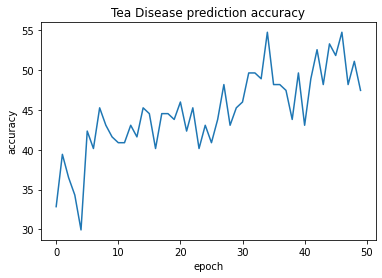

100%|██████████| 50/50 [07:39<00:00,  9.18s/it]


In [ ]:
# @title Train ResNet from scratch
scratch_accs = []
for epoch in tqdm.tqdm(range(50)):
  # Train loop
  for batch in train_dataloaders:
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = resnet(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

  # Eval loop
  with torch.no_grad():
    total = 0
    correct = 0
    total = len(val_dataloaders)
    for batch in val_dataloaders:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = resnet(images)
      probs = torch.nn.Softmax(dim=1)(output)
      predictions = torch.argmax(probs, dim=1)

      correct += int(torch.sum(predictions == labels).cpu().detach().numpy())
      total += len(labels)

    accuracy = correct/total

    scratch_accs.append(accuracy*100)
    plt.plot(scratch_accs)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Tea Disease prediction accuracy')

    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
  plt.close()

In [ ]:
def test(dataloader, device):
    '''Evaluate prediction accuracy on the test dataset.'''
    nb_classes = 8
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    resnet.eval()
    with torch.no_grad():
        #dataloader = DataLoader(test_dataset, batch_size=32)
        #accuracy = evaluate(dataloader, 'test', device)
        correct, total = 0, 0
        for x, y in tqdm.tqdm(dataloader, 'test'):
            x, y = x.to(device), y.to(device)
            logits = resnet(x)
            probs = torch.nn.Softmax(dim=1)(logits)
            predictions = torch.argmax(probs, dim=1)
            #correct += int(torch.sum(predictions == y).cpu().detach().numpy())
            #total += len(y)
            for t, p in zip(y.view(-1), predictions.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        #accuracy = correct/total
        accuracy_per_class = confusion_matrix.diag()/confusion_matrix.sum(1)
        accuracy_overall = confusion_matrix.diag().sum()/confusion_matrix.sum()
    return confusion_matrix, accuracy_per_class*100, accuracy_overall*100

In [ ]:
confusion_matrix, accuracy_per_class, accuracy_overall = test(test_dataloaders, device=DEVICE)
print(f"final test accuracy per class: {accuracy_per_class}")
print(f"final test accuracy overall: {accuracy_overall}")
print(confusion_matrix)

test: 100%|██████████| 5/5 [01:27<00:00, 17.56s/it]

final test accuracy per class: tensor([ 31.5789,  86.6667,  91.6667,  95.4545,  80.0000, 100.0000, 100.0000,
         63.1579])
final test accuracy overall: 80.30303192138672
tensor([[ 6.,  0.,  6.,  0.,  7.,  0.,  0.,  0.],
        [ 0., 13.,  0.,  0.,  0.,  0.,  0.,  2.],
        [ 1.,  0., 11.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 21.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  2.,  0.,  8.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 14.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 21.,  0.],
        [ 0.,  2.,  0.,  5.,  0.,  0.,  0., 12.]])
